![](/images/Capture2.JPG)

#  <center> Avicenna Validation:  Comparing Avicenna Predictions to Reported Data for the State of California </center>

## Background on Lucd

Lucd Avicenna is an Agent Based Modeling and Discrete Event Simulation Platform Capability that provides disease spread projections for pandemic from start to finish including: 
 - **Granular Analysis:**  R values are person to person based on behavior and demographics; NOT applied homogenously across all of population.
 - **Specific to Geographies:**  Model predictions (in this case Susceptible, Exposed, Infected, Recovered) can be assessed for future times for a specific area (in this case modeled down to the Census Tract level).
 - **What If Scenarios:** Allow flexible input on parameters (i.e. time, location, and compliance with stay at home orders); additional data inputs (i.e. model can be enriched) as well as outside expert configuration (i.e. independent epidemiological experts can “turn the knobs”) to visualize future results for each time step and for each geography.

## Discussion on this particular test and evaluation

Lucd Avicenna is a measure of Prevalence (number of cases of a disease that are present in a particular population at a given time) for each day over the life of the Pandemic and therefore allows predictions of disease prevalence into the future).

Reported Data is an attempt at measuring Incidence (number of new cases that develop in a given period of time).  Documented challenges of reported data are numerous.  In addition, Reported Data does not predict into the future.

There are analysis to relate Reported Data to Incidence to Prevalence. For the purposes of analyzing Avicenna, an attempt is made in this analysis to relate reported data to prevalence for the period of time reported data is available.  Then, Avicenna is compared to that result for analysis.

This specific analysis will look at the State of California for a time period for which there is reported data.  Avicenna runs for the life of the spread of the pandemic and is independent of reported data, so we can slice the part of the Avicenna run that corresponds to the date range of the reported data and compare the Avicenna prediction for that date range to the reported data for that date range.

So, this analysis will include three parts:
1. Reading the Avicenna model run into this notebook and extracting a time slice that is the same as the reported data.  Also since Avicenna predicts at the Census Tract level, we will sum all the California Census Tracts for each day in the time slice to an aggregate State of California prediction.
2. Reading in reported data into this notebook and performing transformations to create a prevalence calculated from the reported data for each day in the reported timeframe.
3. Comparing the Avicenna model to the reported data.

## Importing prerequisites to perform the calculation

In [3]:
import pandas as pd
import os
import glob
from os.path import splitext, basename
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
import datetime
from datetime import timedelta
import math
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
%matplotlib inline
pd.set_option('display.max_columns', 500)

## Part 1: Reading the Avicenna model run into this notebook

For this analysis, a latest Avicenna model run is leveraged.  It is important to note, that many Avicenna models have and can be run.  Similar to editing hyperparameters in deep neural networks, Avicenna has input parameters around population, mobility, workplaces, disease initiation, compliance with stay at home orders, etc.  Just like tuning a deep neural network, Avicenna can and should be tuned and input parameters adjusted to compare model runs.  For this initial analysis only a model run for the State of California is used.

The Output of an Avicenna Model run can be viewed as a csv.  The following is a tiny excerpt:

![](images/Avicenna_Output_as_csv.jpg)

For this analysis, we will leverage the following columns:
- **Day:** This is the day of the disease for each day that the disease is present.  For the purposes of this analysis, we are assuming that Day 0 is January 1, 2020.  Day 1, is January 2, 2020, etc.
- **FIPS:** This is the FIPS code for the Census Tract.  Note, the FIPS column also includes particular locations, we will not use these rows for this analysis.
- **Infected Count:**  This is the Infected Count that we will use to compare against reported data.

The following code reads the Avicenna model run output csv into a dataframe and sums each FIPS into its associated county per the above text: (Note, that while not specifically required, we leverage a publicly Gaz-tracts.csv that allows us to get a lat and long for each FIPS, as well as a publicly available national_county.csv that allows us to break assign each census tract to its associated named county.

In [5]:
def new_pandemic_model(epi):
    epi_df = pd.read_csv(epi)
    epi_df = epi_df[pd.to_numeric(epi_df['FIPS'], errors='coerce').notnull()]
    epi_df['FIPS'] = epi_df['FIPS'].astype('int64')
    epi_df = epi_df[epi_df['FIPS'] > 1000000]   

    lat_long_fips_df = pd.read_csv('Gaz_tracts.csv')
    del lat_long_fips_df["Column1"]
    lat_long_fips_df = lat_long_fips_df.rename(columns={'GEOID': 'FIPS'})
    lat_long_fips_df = lat_long_fips_df.rename(columns={'USPS': 'State'})
    del lat_long_fips_df["ALAND"]
    del lat_long_fips_df["AWATER"]
    del lat_long_fips_df["ALAND_SQMI"]
    del lat_long_fips_df['AWATER_SQMI']

    df = pd.merge(epi_df, lat_long_fips_df, on='FIPS', how = 'left')
    df['FIPS_String'] = df['FIPS'].astype(str)
    df['FIPS_String'] = df['FIPS_String'].str[:-6]
    df['FIPS_String'] = df['FIPS_String'].str[-3:]
    df = df.rename(columns={'FIPS_String': 'County_Code'})

    national_county_df = pd.read_csv('national_county.csv', header=None)
    del national_county_df[1]
    del national_county_df[4]
    national_county_df[2] = national_county_df[2].astype(str)
    national_county_df[2] = national_county_df[2].apply(lambda x: x.zfill(3))    
    national_county_df = national_county_df.rename(columns={2: 'County_Code', 3: "County", 0: 'State'})

    
    total_new_df = pd.merge(df, national_county_df, on=['County_Code', 'State'], how = 'left')
    

    pandemic_counties = total_new_df.groupby(['State', 'County', 'Day'])['Infected Count'].sum().reset_index()
    pandemic_counties['County_State'] = pandemic_counties["County"] + ", " + pandemic_counties["State"]
    del pandemic_counties['County']
    del pandemic_counties['State']
    
    
    county_subset = pandemic_counties[['Day', 'County_State', 'Infected Count']]
    county_len = county_subset.Day.max()
    new_pandemic  = pd.DataFrame()
    day_list = list(range(county_len+1))
    new_pandemic['Day'] = pd.Series(day_list)
    for County_State in county_subset.County_State.unique().tolist():
        place_holder = county_subset[county_subset['County_State']  == County_State]
        new_pandemic[County_State] = place_holder['Infected Count'].to_numpy()
    
        
    return new_pandemic

In [6]:
pandemic_mass = new_pandemic_model('AvicennaLogs/California.csv')

In [7]:
pandemic_mass.head()

Day  Alameda County, CA  Alpine County, CA  Amador County, CA  \
0    0                   0                  0                  0   
1    1                   0                  0                  0   
2    2                   0                  0                  0   
3    3                   0                  0                  0   
4    4                   0                  0                  0   

   Butte County, CA  Calaveras County, CA  Colusa County, CA  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   Contra Costa County, CA  Del Norte County, CA  El Dorado County, CA  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   

   Fresno County, CA  Glenn County, CA  Humboldt County, CA  \
0                  0                 0                    0   
1                  0                 0                    0   
2                  0                 0                    0   
3                  0                 0                    0   
4                  0                 0                    0   

   Imperial County, CA  Inyo County, CA  Kern County, CA  Kings County, CA  \
0                    0                0                0                 0   
1                    0                0                0                 0   
2                    0                0                0                 0   
3                    0                0                0                 0   
4                    0                0                0                 0   

   Lake County, CA  Lassen County, CA  Los Angeles County, CA  \
0                0                  0                       0   
1                0                  0                       0   
2                0                  0                       0   
3                0                  0                       0   
4                0                  0                       0   

   Madera County, CA  Marin County, CA  Mariposa County, CA  \
0                  0                 0                    0   
1                  0                 0                    0   
2                  0                 0                    0   
3                  0                 0                    0   
4                  0                 0                    0   

   Mendocino County, CA  Merced County, CA  Modoc County, CA  Mono County, CA  \
0                     0                  0                 0                0   
1                     0                  0                 0                0   
2                     0                  0                 0                0   
3                     0                  0                 0                0   
4                     0                  0                 0                0   

   Monterey County, CA  Napa County, CA  Nevada County, CA  Orange County, CA  \
0                    0                0                  0                  0   
1                    0                0                  0                  0   
2                    0                0                  0                  0   
3                    0                0                  0                  0   
4                    0                0                  0                  0   

   Placer County, CA  Plumas County, CA  Riverside County, CA  \
0                  0                  0                     0   
1                  0                  0   

In [8]:
pandemic_mass.tail()

Day  Alameda County, CA  Alpine County, CA  Amador County, CA  \
270  270              118224                  0               3978   
271  271              118251                  0               3968   
272  272              117954                  0               3966   
273  273              117904                  0               3979   
274  274              117762                  0               3943   

     Butte County, CA  Calaveras County, CA  Colusa County, CA  \
270             16505                  2720               1676   
271             16259                  2685               1682   
272             16015                  2685               1689   
273             15813                  2665               1716   
274             15487                  2670               1721   

     Contra Costa County, CA  Del Norte County, CA  El Dorado County, CA  \
270                    91295                  1287                 13763   
271                    91472                  1254                 13752   
272                    91645                  1247                 13723   
273                    91738                  1235                 13709   
274                    91639                  1204                 13754   

     Fresno County, CA  Glenn County, CA  Humboldt County, CA  \
270              63249              1582                 8030   
271              63022              1575                 7946   
272              62741              1586                 7896   
273              62627              1579                 7864   
274              62426              1557                 7831   

     Imperial County, CA  Inyo County, CA  Kern County, CA  Kings County, CA  \
270                 8166              416            43602              7850   
271                 8142              443            43689              7911   
272                 8144              458            43670              7952   
273                 8113              456            43722              8078   
274                 8135              457            43563              8111   

     Lake County, CA  Lassen County, CA  Los Angeles County, CA  \
270             3821                469                  802735   
271             3810                433                  801057   
272             3784                409                  798966   
273             3797                381                  796703   
274             3787                355                  793942   

     Madera County, CA  Marin County, CA  Mariposa County, CA  \
270               5455             13222                  550   
271               5506             13372                  550   
272               5546             13417                  553   
273               5572             13429                  564   
274               5611             13462                  548   

     Mendocino County, CA  Merced County, CA  Modoc County, CA  \
270                  5181              11398                 0   
271                  5235              11445                 0   
272                  5199              11544                 0   
273                  5201              11575                 0   
274                  5190              11670                 0   

     Mono County, CA  Monterey County, CA  Napa County, CA  Nevada County, CA  \
270              142                19795             7423               3828   
271              143                19881             7357               3843   
272              137                19963             7281               3884   
273              143                20031             7230               3963   
274              144                20202             7111               4023   

     Orange County, CA  Placer County, CA  Plumas County, CA  \
270             175774              19524                999   
271             177137              19619           

The following code assigns a date to each day with Day 0 starting at January 1, 2020

In [9]:
pandemic_mass['Year'] = np.where(pandemic_mass['Day']<366, 2020, 2021)
pandemic_mass['Day'] = np.where(pandemic_mass['Day']>365, (pandemic_mass['Day'] - 366), pandemic_mass['Day'])
pandemic_mass['Date'] = (np.asarray(pandemic_mass['Year'], dtype='datetime64[Y]')-1970)+(np.asarray(pandemic_mass['Day'], dtype='timedelta64[D]'))
pandemic_mass['Day'] = np.where(pandemic_mass['Year']==2021, (pandemic_mass['Day'] + 366), pandemic_mass['Day'])

The following code sums all the California counties into an aggregate "Total" column for the State.

In [10]:
pandemic_mass.columns

Index(['Day', 'Alameda County, CA', 'Alpine County, CA', 'Amador County, CA',
       'Butte County, CA', 'Calaveras County, CA', 'Colusa County, CA',
       'Contra Costa County, CA', 'Del Norte County, CA',
       'El Dorado County, CA', 'Fresno County, CA', 'Glenn County, CA',
       'Humboldt County, CA', 'Imperial County, CA', 'Inyo County, CA',
       'Kern County, CA', 'Kings County, CA', 'Lake County, CA',
       'Lassen County, CA', 'Los Angeles County, CA', 'Madera County, CA',
       'Marin County, CA', 'Mariposa County, CA', 'Mendocino County, CA',
       'Merced County, CA', 'Modoc County, CA', 'Mono County, CA',
       'Monterey County, CA', 'Napa County, CA', 'Nevada County, CA',
       'Orange County, CA', 'Placer County, CA', 'Plumas County, CA',
       'Riverside County, CA', 'Sacramento County, CA',
       'San Benito County, CA', 'San Bernardino County, CA',
       'San Diego County, CA', 'San Francisco County, CA',
       'San Joaquin County, CA', 'San Luis Obispo C

In [11]:
pandemic_mass['Total'] = pandemic_mass[['Alameda County, CA', 'Alpine County, CA', 'Amador County, CA',
       'Butte County, CA', 'Calaveras County, CA', 'Colusa County, CA',
       'Contra Costa County, CA', 'Del Norte County, CA',
       'El Dorado County, CA', 'Fresno County, CA', 'Glenn County, CA',
       'Humboldt County, CA', 'Imperial County, CA', 'Inyo County, CA',
       'Kern County, CA', 'Kings County, CA', 'Lake County, CA',
       'Lassen County, CA', 'Los Angeles County, CA', 'Madera County, CA',
       'Marin County, CA', 'Mariposa County, CA', 'Mendocino County, CA',
       'Merced County, CA', 'Modoc County, CA', 'Mono County, CA',
       'Monterey County, CA', 'Napa County, CA', 'Nevada County, CA',
       'Orange County, CA', 'Placer County, CA', 'Plumas County, CA',
       'Riverside County, CA', 'Sacramento County, CA',
       'San Benito County, CA', 'San Bernardino County, CA',
       'San Diego County, CA', 'San Francisco County, CA',
       'San Joaquin County, CA', 'San Luis Obispo County, CA',
       'San Mateo County, CA', 'Santa Barbara County, CA',
       'Santa Clara County, CA', 'Santa Cruz County, CA', 'Shasta County, CA',
       'Sierra County, CA', 'Siskiyou County, CA', 'Solano County, CA',
       'Sonoma County, CA', 'Stanislaus County, CA', 'Sutter County, CA',
       'Tehama County, CA', 'Trinity County, CA', 'Tulare County, CA',
       'Tuolumne County, CA', 'Ventura County, CA', 'Yolo County, CA',
       'Yuba County, CA']].sum(axis=1)

In [12]:
pandemic_mass.head()

Day  Alameda County, CA  Alpine County, CA  Amador County, CA  \
0    0                   0                  0                  0   
1    1                   0                  0                  0   
2    2                   0                  0                  0   
3    3                   0                  0                  0   
4    4                   0                  0                  0   

   Butte County, CA  Calaveras County, CA  Colusa County, CA  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   Contra Costa County, CA  Del Norte County, CA  El Dorado County, CA  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   

   Fresno County, CA  Glenn County, CA  Humboldt County, CA  \
0                  0                 0                    0   
1                  0                 0                    0   
2                  0                 0                    0   
3                  0                 0                    0   
4                  0                 0                    0   

   Imperial County, CA  Inyo County, CA  Kern County, CA  Kings County, CA  \
0                    0                0                0                 0   
1                    0                0                0                 0   
2                    0                0                0                 0   
3                    0                0                0                 0   
4                    0                0                0                 0   

   Lake County, CA  Lassen County, CA  Los Angeles County, CA  \
0                0                  0                       0   
1                0                  0                       0   
2                0                  0                       0   
3                0                  0                       0   
4                0                  0                       0   

   Madera County, CA  Marin County, CA  Mariposa County, CA  \
0                  0                 0                    0   
1                  0                 0                    0   
2                  0                 0                    0   
3                  0                 0                    0   
4                  0                 0                    0   

   Mendocino County, CA  Merced County, CA  Modoc County, CA  Mono County, CA  \
0                     0                  0                 0                0   
1                     0                  0                 0                0   
2                     0                  0                 0                0   
3                     0                  0                 0                0   
4                     0                  0                 0                0   

   Monterey County, CA  Napa County, CA  Nevada County, CA  Orange County, CA  \
0                    0                0                  0                  0   
1                    0                0                  0                  0   
2                    0                0                  0                  0   
3                    0                0                  0                  0   
4                    0                0                  0                  0   

   Placer County, CA  Plumas County, CA  Riverside County, CA  \
0                  0                  0                     0   
1                  0                  0   

As you will see below, the reporting period for the reported data is March 7 through March 22, we can plot this Total column against that date window

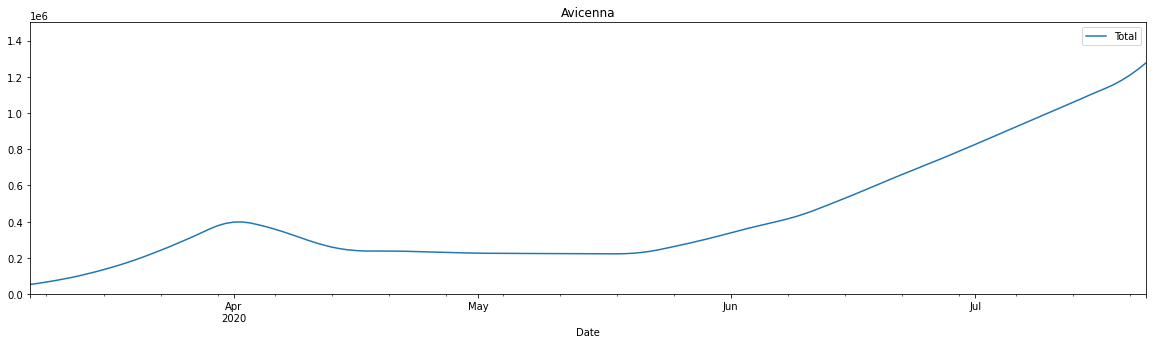

In [13]:
fig, ax = plt.subplots()
pandemic_mass.plot(x='Date', y=['Total'], ax=ax, legend=True, title="Avicenna", figsize=(20,5))
ax.set_xlim([datetime.date(2020, 3, 7), datetime.date(2020, 7, 22)])
ax.set_ylim([0,1500000])
plt.show()

The following code creates a subset dataframe with just the Total column and just the date window that is equivalent to the reported data (below) date window

In [14]:
avi_sc = pandemic_mass[['Day', 'Date', 'Total']]

In [15]:
avi_sc.head()

Day       Date  Total
0    0 2020-01-01      0
1    1 2020-01-02      0
2    2 2020-01-03      0
3    3 2020-01-04      0
4    4 2020-01-05      0

In [16]:
mask = (avi_sc['Date'] > '2020-3-6') & (avi_sc['Date'] <= '2020-7-22')
avi_sc = avi_sc.loc[mask]
avi_sc = avi_sc.reset_index()
del avi_sc['index']

In [17]:
len(avi_sc)

138

In [18]:
avi_sc.head()

Day       Date  Total
0   66 2020-03-07  53894
1   67 2020-03-08  60094
2   68 2020-03-09  67183
3   69 2020-03-10  74608
4   70 2020-03-11  82790

In [19]:
avi_sc.tail()

Day       Date    Total
133  199 2020-07-18  1156540
134  200 2020-07-19  1181064
135  201 2020-07-20  1209071
136  202 2020-07-21  1241217
137  203 2020-07-22  1277323

## Part 2: Reading the reported data into this notebook

There are different websites available to pull reported data around infections.  This notebook uses the following source for reported data:  https://www.csbs.org/information-covid-19-coronavirus
The following person's github site scrapes this data and provides a .csv each day for reported data in each county:  https://github.com/tomquisel/covid19-data/tree/master/data/csv

There are different ways to pull the data down into a folder and then merging each daily .csv into a single dataframe.  Pulling the data into a folder is left to the reader.  The following code creates a "merged" dataframe that can be utilized in this part of the notebook.  Note:  the comparison in Part 3 was done with the last updated .csv from 29 July.  If you follow this code now, the update will be to the current date.  You will then need to update the Part 3 code if you want to analyze up to the current date.

In [20]:
def create_merged():
    #next(os.walk('./County_Data'))[2]
    all_files = glob.glob("County_Data/*.csv")
    all_files.remove('County_Data\\timeseries_confirmed.csv')
    all_files.remove('County_Data\\timeseries_death.csv')

    dfs = {splitext(basename(fp))[0].split('_')[-1] : pd.read_csv(fp) for fp in all_files}
    #dfs.keys()
    #dfs['2020-03-14'].head()
    #dfs['2020-03-14'].dtypes
    #len(dfs)
    #list(dfs.keys())
    #for key in dfs.keys():
    #    print(dfs[key].head())

    for key in dfs.keys():
        df_confirmed = dfs[key].copy()
        break

    #df_confirmed.head()
    #df['Last_Update'] = pd.to_datetime(df['Last_Update'], utc=False)

    column_list = []
    for column_name in df_confirmed.columns:
        #print(column_name)
        if column_name == 'Confirmed':
            column_name = df_confirmed.iloc[0]['Last_Update']
        column_list.append(column_name)
    #column_list

    df_confirmed.columns = column_list
    #df_confirmed.head()
    df_confirmed = df_confirmed[['County_Name', 'State_Name', '2020-03-14 12:04 EDT']]
    #len(df_confirmed)
    #df_confirmed.head()

    i = 0
    for key in dfs.keys():
        if i > 0:
            df_temp = dfs[key].copy()
            df_temp.rename(columns={'Confirmed': df_temp.iloc[0]['Last_Update']}, inplace=True)
            #print(df_temp.columns)
            df_temp = df_temp[['County_Name', 'State_Name', df_temp.iloc[0]['Last_Update']]]
            #print(len(df_temp))
            #print(df_temp.head())
            if i == 1:
                merged = pd.merge(df_confirmed, df_temp, on=['County_Name', 'State_Name'], how='outer')
            if i > 1:
                merged = pd.merge(merged, df_temp, on=['County_Name', 'State_Name'], how='outer')
        i += 1


    #merged.head(10)
    #len(merged)
    merged['County State'] = merged["County_Name"] + ", " + merged ["State_Name"]
    #merged.head()
    del merged['County_Name']
    del merged['State_Name']
    #merged.head()
    #merged.columns
    #merged = merged.rename(columns={'2020-03-16 21:26 UTC': '2020-03-16 21:26 EDT'})

    reported_list = merged.columns.tolist() # list the columns in merged
    reported_list.insert(0, reported_list.pop(reported_list.index('County State'))) # Assign new position (i.e. 0) for "County State"
    #reported_list
    merged = merged.reindex(columns= reported_list) # Now move 'County State' to its new position

    #len(merged.columns)
    #merged.head()
    #merged.tail()
    index_list = merged[(merged['County State'].isnull())].index
    remove_index = index_list[0]
    #merged[(merged['County State'].isnull())].index
    #merged.iloc[[2208]]
    #merged =  merged.drop(merged.index[[2208]]).reset_index(drop=True)
    merged =  merged.drop(merged.index[[remove_index]]).reset_index(drop=True)
    #merged.iloc[[2208]]
    #merged.tail()
    #merged.loc[merged['County State'] == "Albany, New York"]
    
    return merged

In [21]:
merged = create_merged()

In [22]:
merged.head()

County State  2020-03-14 12:04 EDT  2020-03-15 16:23 EDT  \
0        King, Washington                 328.0                 387.0   
1   Snohomish, Washington                 133.0                 154.0   
2  Unassigned, Washington                  65.0                  39.0   
3      Pierce, Washington                  19.0                  26.0   
4       Clark, Washington                   3.0                   3.0   

   2020-03-16 21:26 UTC  2020-03-17 21:54 EDT  2020-03-18 19:42 EDT  \
0                 420.0                 569.0                 562.0   
1                 200.0                 266.0                 310.0   
2                 102.0                  57.0                 165.0   
3                  29.0                  45.0                  56.0   
4                   4.0                   4.0                   4.0   

   2020-03-19 21:57 EDT  2020-03-21 00:57 EDT  2020-03-22 00:28 EDT  \
0                 693.0                 793.0                 934.0   
1                 348.0                 385.0                 447.0   
2                 151.0                 130.0                 146.0   
3                  75.0                  83.0                  95.0   
4                   4.0                   6.0                   9.0   

   2020/03/22 22:06 EDT  2020-03-23 21:39 EDT  2020-03-24 11:13 EDT  \
0                1040.0                1170.0                1170.0   
1                 480.0                 519.0                 519.0   
2                 164.0                 114.0                 112.0   
3                 107.0                 126.0                 126.0   
4                  10.0                  13.0                  13.0   

   2020-03-26 01:00 EDT  2020-03-26 21:06 EDT  2020-03-27 21:58 EDT  \
0                1359.0                1577.0                1828.0   
1                 634.0                 778.0                 913.0   
2                   NaN                  69.0                   0.0   
3                 155.0                 186.0                 231.0   
4                  16.0                  48.0                  76.0   

   2020-03-28 23:49 EDT  2020-03-29 21:44 EDT  2020-03-30 23:54 EDT  \
0                2077.0                2159.0                2330.0   
1                 912.0                 912.0                1127.0   
2                 160.0                 125.0                 274.0   
3                 282.0                 317.0                 352.0   
4                  82.0                  90.0                  90.0   

   2020-03-31 23:54 EDT  2020-04-01 15:53 EDT  2020-04-02 23:49 EDT  \
0                2330.0                2330.0                2656.0   
1                1229.0                1229.0                1376.0   
2                 274.0                 303.0                 501.0   
3                 377.0                 377.0                 498.0   
4                 116.0                 130.0                 131.0   

   2020-04-03 21:59 EDT  2020-04-04 23:16 EDT  2020-04-05 23:45 EDT  \
0                2787.0                2898.0                3167.0   
1                1450.0                1503.0                1559.0   
2                 483.0                 807.0                 648.0   
3                 571.0                 620.0                 688.0   
4                 137.0                 137.0                 145.0   

   2020-04-06 23:21 EDT  2020-04-08 10:37 EDT  2020-04-08 20:36 EDT  \
0                3331.0                3486.0                3688.0   
1                1603.0                1659.0                1695.0   
2                 677.0                 915.0                 838.0   
3                 717.0                 760.0                 795.0   
4                 168.0                 185.0                 190.0   

   2020-04-09 22:52 EDT  2020-04-10 22:54 EDT  2020-04-11 22:58 EDT  \
0                3886.0                4117.0                4262.0   
1               

In [ ]:
#this code writes the merged dataframe to a .csv.  If this has already been done, do not execute.
#or for a new run, execute with a new name
#this notebook executed the below changing the name to "merged_29July.csv"
merged.to_csv('merged.csv')

The next set of cells reads the merged.csv, extracts the California counties only.  It then sums those counties for a reported number for California

In [23]:
merged = pd.read_csv('merged_29July.csv')
del merged["Unnamed: 0"]
merged.head()

County State  2020-03-14 12:04 EDT  2020-03-15 16:23 EDT  \
0        King, Washington                 328.0                 387.0   
1   Snohomish, Washington                 133.0                 154.0   
2  Unassigned, Washington                  65.0                  39.0   
3      Pierce, Washington                  19.0                  26.0   
4       Clark, Washington                   3.0                   3.0   

   2020-03-16 21:26 UTC  2020-03-17 21:54 EDT  2020-03-18 19:42 EDT  \
0                 420.0                 569.0                 562.0   
1                 200.0                 266.0                 310.0   
2                 102.0                  57.0                 165.0   
3                  29.0                  45.0                  56.0   
4                   4.0                   4.0                   4.0   

   2020-03-19 21:57 EDT  2020-03-21 00:57 EDT  2020-03-22 00:28 EDT  \
0                 693.0                 793.0                 934.0   
1                 348.0                 385.0                 447.0   
2                 151.0                 130.0                 146.0   
3                  75.0                  83.0                  95.0   
4                   4.0                   6.0                   9.0   

   2020/03/22 22:06 EDT  2020-03-23 21:39 EDT  2020-03-24 11:13 EDT  \
0                1040.0                1170.0                1170.0   
1                 480.0                 519.0                 519.0   
2                 164.0                 114.0                 112.0   
3                 107.0                 126.0                 126.0   
4                  10.0                  13.0                  13.0   

   2020-03-26 01:00 EDT  2020-03-26 21:06 EDT  2020-03-27 21:58 EDT  \
0                1359.0                1577.0                1828.0   
1                 634.0                 778.0                 913.0   
2                   NaN                  69.0                   0.0   
3                 155.0                 186.0                 231.0   
4                  16.0                  48.0                  76.0   

   2020-03-28 23:49 EDT  2020-03-29 21:44 EDT  2020-03-30 23:54 EDT  \
0                2077.0                2159.0                2330.0   
1                 912.0                 912.0                1127.0   
2                 160.0                 125.0                 274.0   
3                 282.0                 317.0                 352.0   
4                  82.0                  90.0                  90.0   

   2020-03-31 23:54 EDT  2020-04-01 15:53 EDT  2020-04-02 23:49 EDT  \
0                2330.0                2330.0                2656.0   
1                1229.0                1229.0                1376.0   
2                 274.0                 303.0                 501.0   
3                 377.0                 377.0                 498.0   
4                 116.0                 130.0                 131.0   

   2020-04-03 21:59 EDT  2020-04-04 23:16 EDT  2020-04-05 23:45 EDT  \
0                2787.0                2898.0                3167.0   
1                1450.0                1503.0                1559.0   
2                 483.0                 807.0                 648.0   
3                 571.0                 620.0                 688.0   
4                 137.0                 137.0                 145.0   

   2020-04-06 23:21 EDT  2020-04-08 10:37 EDT  2020-04-08 20:36 EDT  \
0                3331.0                3486.0                3688.0   
1                1603.0                1659.0                1695.0   
2                 677.0                 915.0                 838.0   
3                 717.0                 760.0                 795.0   
4                 168.0                 185.0                 190.0   

   2020-04-09 22:52 EDT  2020-04-10 22:54 EDT  2020-04-11 22:58 EDT  \
0                3886.0                4117.0                4262.0   
1               

In [24]:
merged_subset = merged[merged['County State'].str.contains('California')]
merged_subset.head()

County State  2020-03-14 12:04 EDT  2020-03-15 16:23 EDT  \
32    Santa Clara, California                  79.0                 114.0   
33    Los Angeles, California                  40.0                  69.0   
34      San Mateo, California                  26.0                  32.0   
35   Contra Costa, California                  25.0                  29.0   
36  San Francisco, California                  23.0                  37.0   

    2020-03-16 21:26 UTC  2020-03-17 21:54 EDT  2020-03-18 19:42 EDT  \
32                 138.0                 155.0                 175.0   
33                  94.0                 144.0                 190.0   
34                  41.0                  64.0                  80.0   
35                  29.0                  39.0                  39.0   
36                  40.0                  43.0                  51.0   

    2020-03-19 21:57 EDT  2020-03-21 00:57 EDT  2020-03-22 00:28 EDT  \
32                 189.0                 196.0                 263.0   
33                 231.0                 292.0                 351.0   
34                  89.0                 100.0                 110.0   
35                  41.0                  46.0                  51.0   
36                  70.0                  76.0                  84.0   

    2020/03/22 22:06 EDT  2020-03-23 21:39 EDT  2020-03-24 11:13 EDT  \
32                 302.0                 321.0                 321.0   
33                 407.0                 540.0                 540.0   
34                 117.0                 142.0                 142.0   
35                  61.0                  71.0                  71.0   
36                 108.0                 131.0                 131.0   

    2020-03-26 01:00 EDT  2020-03-26 21:06 EDT  2020-03-27 21:58 EDT  \
32                 459.0                 542.0                 574.0   
33                 812.0                1230.0                1465.0   
34                 165.0                 195.0                 239.0   
35                 108.0                 131.0                 147.0   
36                 178.0                 223.0                 279.0   

    2020-03-28 23:49 EDT  2020-03-29 21:44 EDT  2020-03-30 23:54 EDT  \
32                 591.0                 646.0                 848.0   
33                1818.0                2136.0                2474.0   
34                 274.0                 277.0                 309.0   
35                 168.0                 168.0                 187.0   
36                 308.0                 340.0                 374.0   

    2020-03-31 23:54 EDT  2020-04-01 15:53 EDT  2020-04-02 23:49 EDT  \
32                 890.0                 890.0                1019.0   
33                3019.0                3037.0                4045.0   
34                 309.0                 388.0                 453.0   
35                 222.0                 222.0                 276.0   
36                 397.0                 434.0                 450.0   

    2020-04-03 21:59 EDT  2020-04-04 23:16 EDT  2020-04-05 23:45 EDT  \
32                1094.0                1148.0                1207.0   
33                4566.0                5304.0                5955.0   
34                 486.0                 538.0                 555.0   
35                 307.0                 353.0                 386.0   
36                 497.0                 529.0                 568.0   

    2020-04-06 23:21 EDT  2020-04-08 10:37 EDT  2020-04-08 20:36 EDT  \
32                1224.0                1285.0                1380.0   
33                6377.0                7025.0                7559.0   
34                 579.0                 589.0                 617.0   
35                 417.0                 442.0                 462.0   
36                 583.0                 622.0                 676.0   

    2020-04-09 22:52 EDT  2020-04-10 22:54 EDT  2020-04-11 22:58 EDT  \
32                

In [25]:
del merged_subset['County State']
merged_subset.head()

2020-03-14 12:04 EDT  2020-03-15 16:23 EDT  2020-03-16 21:26 UTC  \
32                  79.0                 114.0                 138.0   
33                  40.0                  69.0                  94.0   
34                  26.0                  32.0                  41.0   
35                  25.0                  29.0                  29.0   
36                  23.0                  37.0                  40.0   

    2020-03-17 21:54 EDT  2020-03-18 19:42 EDT  2020-03-19 21:57 EDT  \
32                 155.0                 175.0                 189.0   
33                 144.0                 190.0                 231.0   
34                  64.0                  80.0                  89.0   
35                  39.0                  39.0                  41.0   
36                  43.0                  51.0                  70.0   

    2020-03-21 00:57 EDT  2020-03-22 00:28 EDT  2020/03/22 22:06 EDT  \
32                 196.0                 263.0                 302.0   
33                 292.0                 351.0                 407.0   
34                 100.0                 110.0                 117.0   
35                  46.0                  51.0                  61.0   
36                  76.0                  84.0                 108.0   

    2020-03-23 21:39 EDT  2020-03-24 11:13 EDT  2020-03-26 01:00 EDT  \
32                 321.0                 321.0                 459.0   
33                 540.0                 540.0                 812.0   
34                 142.0                 142.0                 165.0   
35                  71.0                  71.0                 108.0   
36                 131.0                 131.0                 178.0   

    2020-03-26 21:06 EDT  2020-03-27 21:58 EDT  2020-03-28 23:49 EDT  \
32                 542.0                 574.0                 591.0   
33                1230.0                1465.0                1818.0   
34                 195.0                 239.0                 274.0   
35                 131.0                 147.0                 168.0   
36                 223.0                 279.0                 308.0   

    2020-03-29 21:44 EDT  2020-03-30 23:54 EDT  2020-03-31 23:54 EDT  \
32                 646.0                 848.0                 890.0   
33                2136.0                2474.0                3019.0   
34                 277.0                 309.0                 309.0   
35                 168.0                 187.0                 222.0   
36                 340.0                 374.0                 397.0   

    2020-04-01 15:53 EDT  2020-04-02 23:49 EDT  2020-04-03 21:59 EDT  \
32                 890.0                1019.0                1094.0   
33                3037.0                4045.0                4566.0   
34                 388.0                 453.0                 486.0   
35                 222.0                 276.0                 307.0   
36                 434.0                 450.0                 497.0   

    2020-04-04 23:16 EDT  2020-04-05 23:45 EDT  2020-04-06 23:21 EDT  \
32                1148.0                1207.0                1224.0   
33                5304.0                5955.0                6377.0   
34                 538.0                 555.0                 579.0   
35                 353.0                 386.0                 417.0   
36                 529.0                 568.0                 583.0   

    2020-04-08 10:37 EDT  2020-04-08 20:36 EDT  2020-04-09 22:52 EDT  \
32                1285.0                1380.0                1442.0   
33                7025.0                7559.0                7955.0   
34                 589.0                 617.0                 633.0   
35                 442.0                 462.0                 484.0   
36                 622.0                 676.0                 724.0   

    2020-04-10 22:54 EDT  2020-04-11 22:58 EDT  2020-04-12 22:38 EDT  \
32                1484.0           

In [26]:
sc_infections = merged_subset.sum(axis=0, skipna = True)
sc_infections.head()

2020-03-14 12:04 EDT    306.0
2020-03-15 16:23 EDT    424.0
2020-03-16 21:26 UTC    530.0
2020-03-17 21:54 EDT    713.0
2020-03-18 19:42 EDT    828.0
dtype: float64

In [27]:
sc_infections.dtypes

dtype('float64')

In [28]:
sc = pd.DataFrame({'Date':sc_infections.index, 'Total_Reported_Infections':sc_infections.values})
sc.tail()

Date  Total_Reported_Infections
133  2020-07-25 15:31 EDT                   440560.0
134  2020-07-26 14:00 EDT                   448587.0
135  2020-07-27 14:30 EDT                   453155.0
136  2020-07-28 13:20 EDT                   463635.0
137  2020-07-29 13:35 EDT                   473785.0

Now we can plot the reported data for California

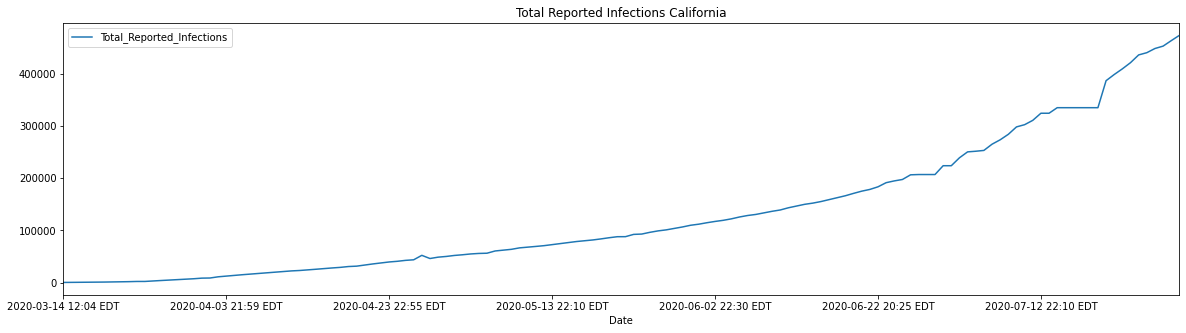

In [29]:
fig, ax = plt.subplots()
sc.plot(x='Date', y=['Total_Reported_Infections'], ax=ax, legend=True, 
        title="Total Reported Infections California", figsize=(20,5))

We now have to do a few things to the reported data so that it can be compared to the Avicenna dat a as described in the introduction

The first thing we need to do is note to note that reported data is an ever increasing some.  It does not subtract out people that had the disease but are no longer infected.  There are numerous reports on how long someone can be infected.  For the purpose of this notebook, we assume that on average a person has the disease for 12 days.  Therefore after 12 days, the reported number should subtract those people.  (note, for the first 12 days, we do not subtract out because there is nothing to subtract from)

The following code performs this calculation

In [30]:
sc['Infected_Calculated_from_Reported'] = sc['Total_Reported_Infections'].diff(12)

In [31]:
for index, row in sc.iterrows():
    if index < 12:
        temp = row['Total_Reported_Infections']
        sc.loc[index, 'Infected_Calculated_from_Reported'] = temp
sc.head(15)

Date  Total_Reported_Infections  \
0   2020-03-14 12:04 EDT                      306.0   
1   2020-03-15 16:23 EDT                      424.0   
2   2020-03-16 21:26 UTC                      530.0   
3   2020-03-17 21:54 EDT                      713.0   
4   2020-03-18 19:42 EDT                      828.0   
5   2020-03-19 21:57 EDT                     1031.0   
6   2020-03-21 00:57 EDT                     1243.0   
7   2020-03-22 00:28 EDT                     1507.0   
8   2020/03/22 22:06 EDT                     1799.0   
9   2020-03-23 21:39 EDT                     2203.0   
10  2020-03-24 11:13 EDT                     2227.0   
11  2020-03-26 01:00 EDT                     3169.0   
12  2020-03-26 21:06 EDT                     4019.0   
13  2020-03-27 21:58 EDT                     4813.0   
14  2020-03-28 23:49 EDT                     5632.0   

    Infected_Calculated_from_Reported  
0                               306.0  
1                               424.0  
2                               530.0  
3                               713.0  
4                               828.0  
5                              1031.0  
6                              1243.0  
7                              1507.0  
8                              1799.0  
9                              2203.0  
10                             2227.0  
11                             3169.0  
12                             3713.0  
13                             4389.0  
14                             5102.0

Reported data, due to inconsistencies, is also known to be "spikey" (i.e. have large changes day to day that are more due to reporting inconsistencies).  Typically analysis leverages taking a rolling mean in order to "smooth out" reported data.  This analysis takes a rolling 7 day mean per the following code.  And again, in order to not lose the first 7 days of data, the first 7 days are leveraged without a rolling mean.

In [ ]:
for index, row in sc.iterrows():
    if index < 12:
        temp = row['Total_Reported_Infections']
        sc.loc[index, 'Infected_Calculated_from_Reported'] = temp

sc.head(15)

In [32]:
sc['Infected_Calculated_from_Reported'] = sc['Infected_Calculated_from_Reported'].rolling(window=7).mean()

In [33]:
for index, row in sc.iterrows():
    if index < 6:
        temp = row['Total_Reported_Infections']
        sc.loc[index, 'Infected_Calculated_from_Reported'] = temp
sc.head(15)

Date  Total_Reported_Infections  \
0   2020-03-14 12:04 EDT                      306.0   
1   2020-03-15 16:23 EDT                      424.0   
2   2020-03-16 21:26 UTC                      530.0   
3   2020-03-17 21:54 EDT                      713.0   
4   2020-03-18 19:42 EDT                      828.0   
5   2020-03-19 21:57 EDT                     1031.0   
6   2020-03-21 00:57 EDT                     1243.0   
7   2020-03-22 00:28 EDT                     1507.0   
8   2020/03/22 22:06 EDT                     1799.0   
9   2020-03-23 21:39 EDT                     2203.0   
10  2020-03-24 11:13 EDT                     2227.0   
11  2020-03-26 01:00 EDT                     3169.0   
12  2020-03-26 21:06 EDT                     4019.0   
13  2020-03-27 21:58 EDT                     4813.0   
14  2020-03-28 23:49 EDT                     5632.0   

    Infected_Calculated_from_Reported  
0                          306.000000  
1                          424.000000  
2                          530.000000  
3                          713.000000  
4                          828.000000  
5                         1031.000000  
6                          725.000000  
7                          896.571429  
8                         1093.000000  
9                         1332.000000  
10                        1548.285714  
11                        1882.714286  
12                        2265.857143  
13                        2715.285714  
14                        3228.857143

The next calculation that needs to be performed is analyzing a reported infection date vs the date that a person is infected.  There is a lag between when a person is infected, to when they start feeling ill, to when they go get tested, to when the test results come back, and to when the positive test result is included in daily reported data. For the purposes of this notebook, a timelag of 7 days is used, per the following code.

In [34]:
sc.Date = sc.Date.astype('str')
sc['Date'] = sc['Date'].str.split(' ').str[0]
sc['Date'] = pd.to_datetime(sc['Date'])
sc['date_minus_one_week'] = sc["Date"] - timedelta(days=7)
sc.tail()

Date  Total_Reported_Infections  Infected_Calculated_from_Reported  \
133 2020-07-25                   440560.0                      101434.000000   
134 2020-07-26                   448587.0                      108849.571429   
135 2020-07-27                   453155.0                      111023.571429   
136 2020-07-28                   463635.0                      115031.000000   
137 2020-07-29                   473785.0                      119549.428571   

    date_minus_one_week  
133          2020-07-18  
134          2020-07-19  
135          2020-07-20  
136          2020-07-21  
137          2020-07-22

We can now plot the reported data after the above calculations.

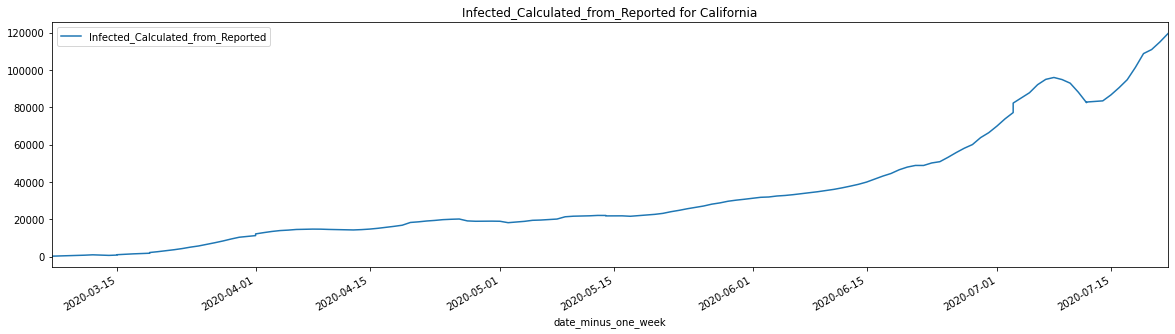

In [36]:
fig, ax = plt.subplots()
sc.plot(x='date_minus_one_week', y=['Infected_Calculated_from_Reported'], ax=ax, legend=True, 
        title="Infected_Calculated_from_Reported for California", figsize=(20,5))

We can now compare the Avicenna predictions to the Reported data for a given window

## Part 3: Comparing the Avicenna model to the reported data

First lets extract only the needed information from the Avicenna dataframe

In [37]:
avi_sc = pandemic_mass[['Day', 'Date', 'Total']]
mask = (avi_sc['Date'] > '2020-3-6') & (avi_sc['Date'] <= '2020-7-22')
avi_sc = avi_sc.loc[mask]
avi_sc = avi_sc.reset_index()
del avi_sc['index']
avi_sc.tail()

Day       Date    Total
133  199 2020-07-18  1156540
134  200 2020-07-19  1181064
135  201 2020-07-20  1209071
136  202 2020-07-21  1241217
137  203 2020-07-22  1277323

make sure both dataframes have the same length and have the same date window

In [38]:
len(avi_sc), len(sc)

(138, 138)

In [39]:
avi_sc.head(), sc.head()

(   Day       Date  Total
 0   66 2020-03-07  53894
 1   67 2020-03-08  60094
 2   68 2020-03-09  67183
 3   69 2020-03-10  74608
 4   70 2020-03-11  82790,
         Date  Total_Reported_Infections  Infected_Calculated_from_Reported  \
 0 2020-03-14                      306.0                              306.0   
 1 2020-03-15                      424.0                              424.0   
 2 2020-03-16                      530.0                              530.0   
 3 2020-03-17                      713.0                              713.0   
 4 2020-03-18                      828.0                              828.0   
 
   date_minus_one_week  
 0          2020-03-07  
 1          2020-03-08  
 2          2020-03-09  
 3          2020-03-10  
 4          2020-03-11  )

In [40]:
avi_sc.tail(), sc.tail()

(     Day       Date    Total
 133  199 2020-07-18  1156540
 134  200 2020-07-19  1181064
 135  201 2020-07-20  1209071
 136  202 2020-07-21  1241217
 137  203 2020-07-22  1277323,
           Date  Total_Reported_Infections  Infected_Calculated_from_Reported  \
 133 2020-07-25                   440560.0                      101434.000000   
 134 2020-07-26                   448587.0                      108849.571429   
 135 2020-07-27                   453155.0                      111023.571429   
 136 2020-07-28                   463635.0                      115031.000000   
 137 2020-07-29                   473785.0                      119549.428571   
 
     date_minus_one_week  
 133          2020-07-18  
 134          2020-07-19  
 135          2020-07-20  
 136          2020-07-21  
 137          2020-07-22  )

Now we can merge the dataframes into one dataframe and perform some cleanup to make more readable

In [41]:
df = pd.concat([avi_sc, sc], axis=1)
del df['Date']
df = df.rename(columns={'Total': 'Avicenna'})
df.tail()

Day  Avicenna  Total_Reported_Infections  \
133  199   1156540                   440560.0   
134  200   1181064                   448587.0   
135  201   1209071                   453155.0   
136  202   1241217                   463635.0   
137  203   1277323                   473785.0   

     Infected_Calculated_from_Reported date_minus_one_week  
133                      101434.000000          2020-07-18  
134                      108849.571429          2020-07-19  
135                      111023.571429          2020-07-20  
136                      115031.000000          2020-07-21  
137                      119549.428571          2020-07-22

We can plot the Avicenna infections vs the reported infections per the below

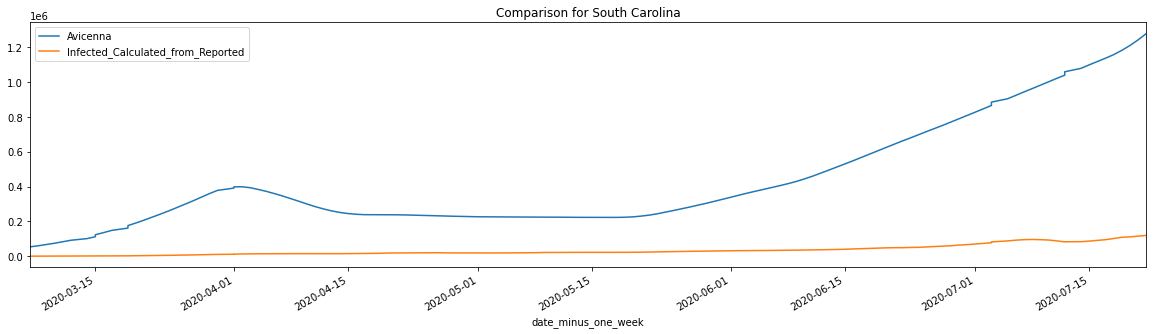

In [42]:
ax = df.plot('date_minus_one_week',['Avicenna', 'Infected_Calculated_from_Reported'], 
             figsize=(20,5), title="Comparison for South Carolina")

**Discussion on Avicenna Prevalence vs Reported Incidence**

As discussed in the introduction, it is known that disease Prevalence is higher than Incidence (unless there is complete continuous testing of the population).  The question becomes how to compare Prevalence to Incidence.

The following paper makes an attempt at this:  https://www.medrxiv.org/content/10.1101/2020.04.20.20072942v1.full.pdf

This reports all state that the ration is 12 on average:
https://www.nytimes.com/2020/06/27/health/coronavirus-antibodies-asymptomatic.html
https://www.washingtonpost.com/health/2020/06/15/patients-with-underlying-conditions-were-12-times-more-likely-die-covid-19-than-otherwise-healthy-people-cdc-finds/
https://www.bostonglobe.com/2020/06/30/nation/actual-number-covid-19-cases-is-12-times-higher-than-reported-with-50-percent-more-deaths-says-mit-study/

Therefore the following code multiplies the reported incidence by 12

In [43]:
df["Prevalence_Calculated_from_Reported"] = df['Infected_Calculated_from_Reported']*12

Now this Prevalence calculated from reported can plotted and compared to Avicenna

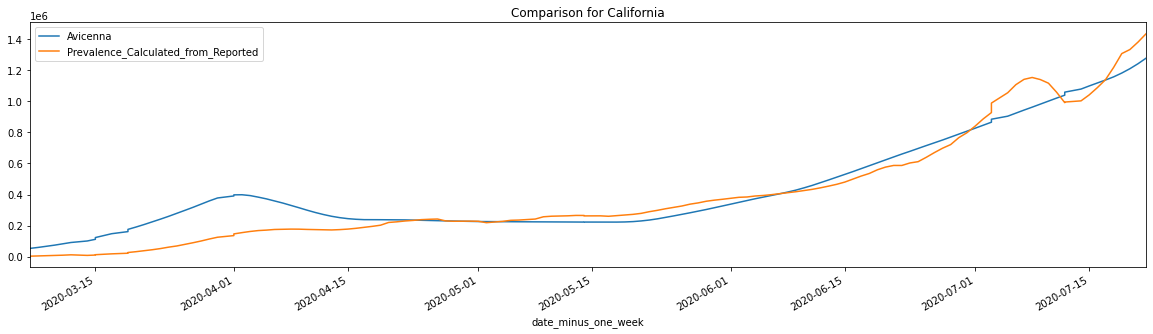

In [44]:
ax = df.plot('date_minus_one_week',['Avicenna', 'Prevalence_Calculated_from_Reported'], 
             figsize=(20,5), title="Comparison for California")

The following code compares the two curves by taking a root mean squared error between the two curves

In [46]:
california_avicenna = df['Avicenna'].tolist()
california_prevalence = df['Prevalence_Calculated_from_Reported'].tolist()
rms = sqrt(mean_squared_error(california_avicenna, california_prevalence))

In [47]:
rms

104336.45737493564

It is sometimes difficult to get a feel for Root Mean Squared Error mean.  So, while not an data scientific approach, we can take this Root Mean Squared Error and compare it to the largest magnitude of the curve to give a "quasi-accuracy" number

In [49]:
(1- (104336/1400000))*100

92.54742857142857

So, while the visual comparison of the curves above is more meaningful from a data science approach.  This quasi-accuracy returns 92.5%